## 1. Kütüphaneler ve Veri Yükleme


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Grafik stili
sns.set_style("whitegrid")

# Veriyi Yükle
try:
    df = pd.read_csv('../data/google_play_store_dataset.csv')
    print("✅ Veri başarıyla yüklendi.")
    print(f"Boyut: {df.shape}")
except FileNotFoundError:
    print("❌ HATA: Veri dosyası bulunamadı.")

✅ Veri başarıyla yüklendi.
Boyut: (10841, 13)


## 2. Temel Temizlik ve Tip Dönüşümleri


In [ ]:

# Hatalı satırı at
df.drop(10472, inplace=True, errors='ignore')

# Temizlik Fonksiyonları
def clean_currency(x):
    return float(str(x).replace('$', '')) if '$' in str(x) else float(x)

def clean_installs(x):
    return int(str(x).replace('+', '').replace(',', '')) if '+' in str(x) else int(str(x).replace(',', ''))

def clean_size(size):
    if 'M' in str(size):
        return float(str(size).replace('M', '')) * 1_000_000
    elif 'k' in str(size):
        return float(str(size).replace('k', '')) * 1_000
    else:
        return np.nan

# Dönüşümleri Uygula
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
df['Price'] = df['Price'].apply(clean_currency)
df['Installs'] = df['Installs'].apply(clean_installs)
df['Size'] = df['Size'].map(clean_size)

# Eksikleri Basitçe Ortalama ile Doldur (Baseline için yeterli)
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())
df['Size'] = df['Size'].fillna(df['Size'].mean())

print("✅ Temizlik tamamlandı. Tüm kritik sütunlar sayısal formatta.")

✅ Temizlik tamamlandı. Tüm kritik sütunlar sayısal formatta.



Bu adımda, ham veri setindeki **metin (string)** formatındaki veriler, modelin işleyebileceği **sayısal (numeric)** formatlara dönüştürülmüştür.

Yapılan İşlemler:
* **Hatalı Satır:** Kaydırma hatası içeren `10472` nolu satır veri setinden çıkarıldı.
* **Sembol Temizliği:**
    * **Price:** '$' işareti kaldırılarak sayıya çevrildi.
    * **Installs:** '+' ve ',' işaretleri kaldırılarak tamsayıya (integer) çevrildi.
* **Birim Dönüşümü (Size):** 'M' (Megabyte) ve 'k' (Kilobyte) ifadeleri matematiksel olarak hesaplanıp (x1.000.000 vb.) saf sayıya dönüştürüldü.
* **Eksik Veriler (Imputation):** Baseline modelin hata vermemesi için, boş olan `Rating` ve `Size` değerleri **basit ortalama (mean)** ile dolduruldu.

**Sonuç:** Veri seti artık matematiksel işlemlere hazır hale geldi.

## 3. Kategorik Verileri Sayısala Çevirme (Label Encoding)


In [ ]:

le = LabelEncoder()
cat_cols = ['Category', 'Type', 'Content Rating', 'Genres']

for col in cat_cols:
    # Eksikleri 'Unknown' metniyle doldurup dönüştürelim
    df[col] = df[col].fillna('Unknown')
    df[col] = le.fit_transform(df[col].astype(str))
    
print("✅ Kategorik veriler (Category, Type vb.) sayısal hale getirildi.")

✅ Kategorik veriler (Category, Type vb.) sayısal hale getirildi.




Makine öğrenmesi modelleri (Random Forest, Regresyon vb.) metin verilerini ("GAME", "Family", "Free" gibi kelimeleri) doğrudan işleyemez; sadece sayılarla çalışırlar. Bu adımda bu çeviri işlemini gerçekleştirdik.

* **Yapılan İşlem (Label Encoding):** `Category`, `Type`, `Content Rating` ve `Genres` sütunlarındaki her bir benzersiz kelimeye rastgele bir sayısal kimlik (ID) atadık.
    * *Örnek:* "ART_AND_DESIGN" $\rightarrow$ `0`, "GAME" $\rightarrow$ `15`, "TOOLS" $\rightarrow$ `28` gibi.
* **Güvenlik Önlemi:** Kodun hata vermemesi için, bu sütunlarda olası boş (NaN) değerleri `'Unknown'` (Bilinmeyen) etiketiyle doldurduk.
* **Sonuç:** Veri setindeki tüm sözel ifadeler artık sayısaldır ve model eğitimi için hazırdır.

## 4. Train - Test Ayrımı


In [ ]:

# Hedef değişken (y) ve Özellikler (X)
# App ismini, tarihleri ve versiyonları şimdilik atıyoruz (Feature Engineering'de kullanacağız)
X = df.drop(columns=['App', 'Rating', 'Last Updated', 'Current Ver', 'Android Ver'])
y = df['Rating']

# %80 Eğitim, %20 Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Eğitim Seti Boyutu: {X_train.shape}")
print(f"Test Seti Boyutu  : {X_test.shape}")

Eğitim Seti Boyutu: (8672, 8)
Test Seti Boyutu  : (2168, 8)




Modeli eğitmeden önce veriyi **Girdi (X)** ve **Hedef (y)** olarak ayırdık ve ardından modelin performansını adil bir şekilde ölçebilmek için **Eğitim** ve **Test** setlerini oluşturduk.

* **Hedef Değişken ($y$):** Tahmin etmeye çalıştığımız **'Rating'** (Puan) sütunudur.
* **Bağımsız Değişkenler ($X$):** Puanı etkileyen faktörlerdir.
    * *Not:* Baseline modelin basit olması için henüz işlenmemiş karmaşık metin sütunları ('App', 'Last Updated' vb.) bu aşamada **dışarıda bırakılmıştır**.
* **80/20 Kuralı:** Verinin **%80'i** modelin öğrenmesi (Train), **%20'si** ise modelin hiç görmediği veriler üzerinde sınav olması (Test) için ayrılmıştır.
* **Random State 42:** Her çalıştırmada aynı ayrımı yapması ve sonuçların tutarlı olması için rastgelelik sabitlenmiştir.

## 5. Model Eğitimi ve Karşılaştırma


🚀 Modeller Yarışıyor...

✅ Dummy Model (Ortalama) tamamlandı. R2: -0.0000
✅ Linear Regression tamamlandı. R2: 0.0097
✅ Random Forest (Baseline) tamamlandı. R2: 0.1141

🏆 FİNAL SKOR TABLOSU (BASELINE)
                      Model  MAE (Hata)  R2 Score
2  Random Forest (Baseline)    0.283741  0.114065
1         Linear Regression    0.306364  0.009741
0    Dummy Model (Ortalama)    0.304731 -0.000016


C:\Users\fatmanur\AppData\Local\Temp\ipykernel_11420\2531956262.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="R2 Score", y="Model", data=results_df, palette="viridis")


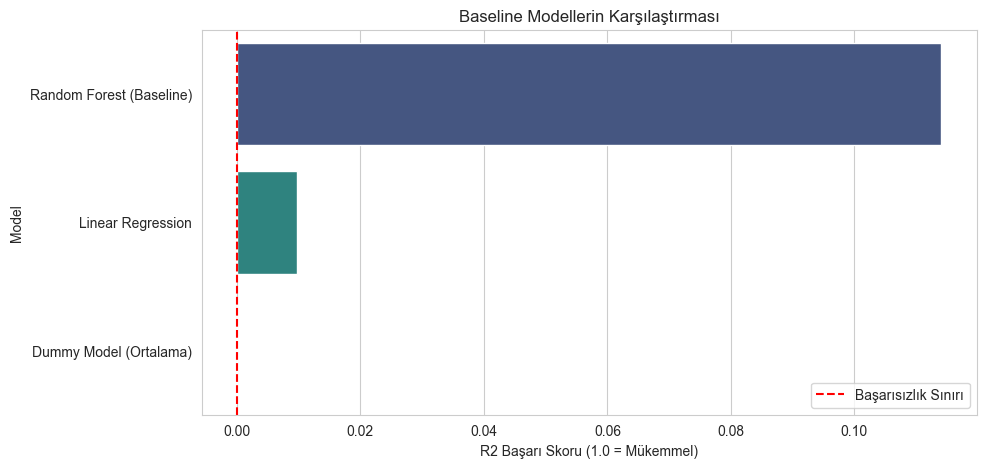

In [ ]:

# Modelleri Sözlükte Tutalım
models = {
    "Dummy Model (Ortalama)": DummyRegressor(strategy="mean"),
    "Linear Regression": LinearRegression(),
    "Random Forest (Baseline)": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = []

print("🚀 Modeller Yarışıyor...\n")

for name, model in models.items():
    # Modeli Eğit
    model.fit(X_train, y_train)
    
    # Tahmin Yap
    y_pred = model.predict(X_test)
    
    # Hata ve Başarı Skorunu Hesapla
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({"Model": name, "MAE (Hata)": mae, "R2 Score": r2})
    print(f"✅ {name} tamamlandı. R2: {r2:.4f}")

# Sonuçları Tabloya Dök
results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)

print("\n" + "="*40)
print("🏆 FİNAL SKOR TABLOSU (BASELINE)")
print("="*40)
print(results_df)

# Görselleştirme
plt.figure(figsize=(10, 5))
sns.barplot(x="R2 Score", y="Model", data=results_df, palette="viridis")
plt.title("Baseline Modellerin Karşılaştırması")
plt.xlabel("R2 Başarı Skoru (1.0 = Mükemmel)")
plt.axvline(0, color='red', linestyle='--', label="Başarısızlık Sınırı")
plt.legend()
plt.show()


Bu adımda, hiçbir **Özellik Mühendisliği (Feature Engineering)** yapmadan, sadece ham veriyi sayıya çevirerek üç farklı modeli yarıştırdık. Amacımız, projenin başlangıç noktasını (Baseline) belirlemektir.

#### Sonuçlar Tablosu:
| Model | R2 Skoru (Başarı) | MAE (Hata) | Yorum |
| :--- | :--- | :--- | :--- |
| **Random Forest (Baseline)** | **0.1141** | 0.2837 | En iyi performansı gösterdi. Karmaşık ilişkileri yakalayabiliyor. |
| **Linear Regression** | 0.0097 | 0.3064 | Çok düşük performans. Veri seti doğrusal bir çizgiyle açıklanamaz. |
| **Dummy Model (Ortalama)** | -0.0000 | 0.3047 | Başarısızlık sınırı. Herkese ortalama puan vermek işe yaramıyor. |

#### Çıkarımlar:
1.  **Kazanan:** **Random Forest** algoritması, diğerlerine göre açık ara önde. Bu, veri setimizde **doğrusal olmayan (non-linear)** ve karmaşık ilişkiler olduğunu gösterir.
2.  **Mevcut Durum:** %11.4'lük bir açıklayıcılık oranı (R2) oldukça düşüktür. Bu, modelin henüz "Uygulama Puanı"nı etkileyen faktörleri (Örn: Son güncelleme tarihi, Başlık uzunluğu vb.) bilmemesinden kaynaklanıyor.
3.  **Hedef:** Bir sonraki aşama olan **Feature Engineering** ile bu skoru yukarı çekmeye çalışacağız.